In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

#Evaluation Metric
from sklearn.metrics import r2_score  # how well we are explaining our variants wrt regression
from sklearn.metrics import cohen_kappa_score  
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import mlxtend
import joblib
import pickle
import sys
from google.colab import files
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS   #Forward Feature Selection

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Approach01: Traditional Features**

### **Filtering DataFrame**


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv("/content/drive/My Drive/IntelliTech-DataSet/Features/EssaySet03_Features.csv", index_col =0)
df_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Accuracy,Lexical_Originality
0,5978,The features of the setting affect the cyclist...,1,1,1,3,54,264,3.925926,18.000000,...,0.610723,2.810930,80.465000,2.614783,7.160967,27,0.500000,27,0,0.000127
1,5979,The features of the setting affected the cycli...,2,2,2,12,226,1016,3.730088,18.833333,...,0.189376,13.730948,96.381114,3.269508,6.736518,97,0.429204,94,4,0.000455
2,5980,Everyone travels to unfamiliar places. Sometim...,1,1,1,8,110,512,3.790909,13.750000,...,0.226976,5.994507,94.435114,0.790625,6.758773,66,0.600000,66,0,0.000310
3,5981,I believe the features of the cyclist affected...,1,1,1,3,93,433,3.709677,31.000000,...,0.183701,6.704974,77.124839,8.611111,7.381304,50,0.537634,58,3,0.000235
4,5982,The setting effects the cyclist because of the...,2,2,2,3,149,701,3.818792,49.666667,...,0.494279,35.227091,61.035414,16.715476,8.007483,65,0.436242,78,2,0.000305


In [3]:
df_train.columns

Index(['ID', 'Essay', 'Rater_1 Score', 'Rater_2 Score', 'Total Score',
       'Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count',
       'Avg_Sentence_Length', 'Preprocessed_Essay', 'Syllable_Count',
       'Difficult_Word_Count', 'Verb_Count', 'Noun_Count', 'Adj_Count',
       'Conj_Count', 'Adverb_Count', 'pNoun_Count', 'Spelling_Mistakes_Count',
       'Without_White_Spaces', 'Essay_SpellingCorrected_LT', 'Count_Fullstops',
       'Count_Exclamation', 'Count_Comma', 'Count_Questionmark',
       'Count_Hyphens', 'Capitalization_Errors', 'Grammar_Error_Count',
       'Grammar_Error_List', 'Sentences_Tokenized', 'Semantic_Similarity',
       'Connectivity_Index', 'Flesch_Reading_Ease_Score',
       'Flesh_Kincaid_Grade', 'Dale_Challl_Readability_Score',
       'Unique_Words_LD', 'Lexical_Diversity', 'Lexical_Density',
       'Lexical_Accuracy', 'Lexical_Originality'],
      dtype='object')

In [4]:
feats = ['Total Score', 'Sent_Count', 'Word_Count', 'Char_Count',
       'Avg_Word_Count', 'Avg_Sentence_Length', 'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count',
       'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count',
       'Spelling_Mistakes_Count','Count_Fullstops', 'Count_Exclamation',
       'Count_Comma', 'Count_Questionmark', 'Count_Hyphens',
       'Capitalization_Errors', 'Grammar_Error_Count', 'Semantic_Similarity', 'Connectivity_Index',
       'Flesch_Reading_Ease_Score', 'Flesh_Kincaid_Grade',
       'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity',
       'Lexical_Density', 'Lexical_Originality', 'Lexical_Accuracy']
df_train = df_train.loc[:, df_train.columns.isin(feats)]

In [5]:
df_train.head()

,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Syllable_Count,Difficult_Word_Count,Verb_Count,Noun_Count,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Accuracy,Lexical_Originality
0,1,3,54,264,3.925926,18.000000,69,9,5,15,...,0.610723,2.810930,80.465000,2.614783,7.160967,27,0.500000,27,0,0.000127
1,2,12,226,1016,3.730088,18.833333,244,31,20,34,...,0.189376,13.730948,96.381114,3.269508,6.736518,97,0.429204,94,4,0.000455
2,1,8,110,512,3.790909,13.750000,128,17,15,19,...,0.226976,5.994507,94.435114,0.790625,6.758773,66,0.600000,66,0,0.000310
3,1,3,93,433,3.709677,31.000000,108,13,12,19,...,0.183701,6.704974,77.124839,8.611111,7.381304,50,0.537634,58,3,0.000235
4,2,3,149,701,3.818792,49.666667,168,18,13,32,...,0.494279,35.227091,61.035414,16.715476,8.007483,65,0.436242,78,2,0.000305


Apply transformations to make target variable more normally distributed for regression.

### **Transforming Target for Normal Distribution**
1. Log Test
2. Square Root
3. Box Cox

#### Visualizing Data

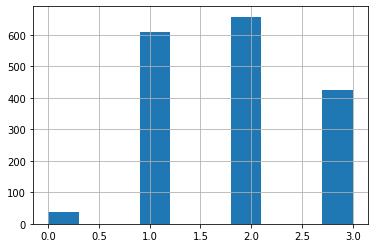

In [ ]:
df_train['Total Score'].hist()

In [ ]:
#This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.
#If the p-value > 0.05, then it is bell-curve distribution.
#Our data is clearly right skewed (Histogram)
normaltest(df_train['Total Score'].values)  

NormaltestResult(statistic=402.90265559591194, pvalue=3.241902618936217e-88)

In [ ]:
df_train['Total Score'].describe()   #Range of total score for essayset01 is 2-12, and histogram shows majority has scored between above 8.

count    1726.000000
mean        1.848204
std         0.815157
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: Total Score, dtype: float64

#### 1. Log Test

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: ignored

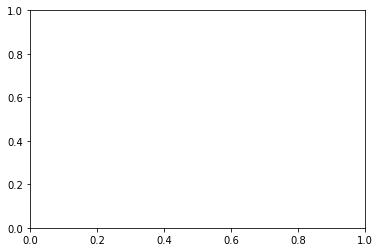

In [ ]:
log_scores = np.log(df_train['Total Score'])
log_scores.hist();

In [ ]:
log_scores

0       2.079442
1       2.197225
2       1.945910
3       2.302585
4       2.079442
          ...   
1778    2.079442
1779    1.945910
1780    2.079442
1781    0.693147
1782    1.945910
Name: Total Score, Length: 1783, dtype: float64

In [ ]:
normaltest(log_scores)   # No significant change in p-value

NormaltestResult(statistic=967.9747627089553, pvalue=6.411371863278859e-211)

#### 2. Square Root Transformation

(array([ 10.,   1.,  17.,   0.,  17., 110., 822., 334., 316., 156.]),
 array([1.41421356, 1.61920237, 1.82419117, 2.02917998, 2.23416878,
        2.43915759, 2.64414639, 2.8491352 , 3.054124  , 3.25911281,
        3.46410162]),
 <a list of 10 Patch objects>)

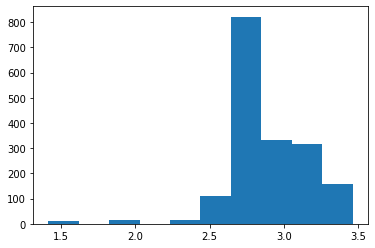

In [ ]:
sqrt_scores = np.sqrt(df_train['Total Score'])
plt.hist(sqrt_scores)

In [ ]:
normaltest(sqrt_scores)

NormaltestResult(statistic=456.280616698139, pvalue=8.316162831695822e-100)

#### 3. BoxCox



In [ ]:
bc_result = boxcox(df_train['Total Score'])
boxcox_score = bc_result[0]
lam = bc_result[1]
lam

1.5655301834951507

In [ ]:
boxcox_score.shape

(1783,)

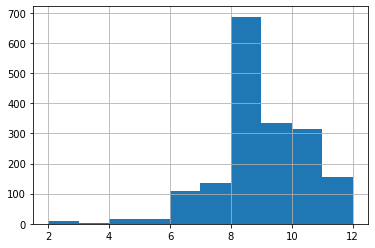

In [ ]:
df_train['Total Score'].hist();

In [ ]:
normaltest(boxcox_score)

NormaltestResult(statistic=17.904988751361316, pvalue=0.00012941395009995448)

Significantly more normally distributed (according to p value) than the other two distributions

### **Box Plot**
This is essentially done to visualize the outliers in the target score. This step will tell us if we need to scale our values or not.


Minimum: 5 <BR/>
Q1(25%): 8 <BR/>
Q2(50%): 8.5 <BR/>
Q3(75%): 10 <BR/>
Maximum: 12 <BR/>
The plot suggests that we have outliers in our dataset that might ruin the predictive power of our model.

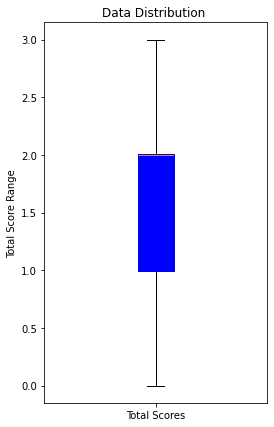

In [6]:
plt.figure(figsize =(4,7))   #Vertical box-plots gives good visualization
plt.style.use("default")
boxes = plt.boxplot(df_train['Total Score'], labels= ['Total Scores'], patch_artist = True)
plt.title("Data Distribution ")
plt.ylabel("Total Score Range")
for box in boxes['boxes']:
    box.set(color = "blue", linewidth= 3, hatch= '/', facecolor= "orange")
plt.show()

## **Model Tracking**

In [7]:
log_df = pd.DataFrame(columns = ['modelName', 'features_list', 'features_size', 'hyperparameters', 'scaling_type', 'no_of_kfolds','comments','r2-score', 'mae','cohen_kappa_score'])

In [8]:
class Logger_Regression:
    modelName = "",      # linearRegression,lasso,ridge, SVR 
    features_list = list(),
    features_size = 0,
    hyperparameters = "none",  #alpha_value, max_iteration
    scaling_type = "none",    #standard, minmax, maxabs
    no_of_kfolds = 0,
    comments = "",
    r2_score = 0,
    mae = 0,
    cohen_kappa_score = 0

    def  __init__(self, modelName, feature_list, features_size):
      self.modelName = modelName
      self.features_list = feature_list
      self.features_size = features_size

    ############################ Linear Regression ###############################
    def linearRegression_basic(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      lr = LinearRegression()
      lr.fit(X_train, y_train)
      y_pred = lr.predict(X_test)
      #print(y_pred[:10])
      #print(y_test[:10])
      self.r2_score = r2_score(y_test,y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)
      self.cohen_kappa_score=cohen_kappa_score(np.floor(y_pred), np.floor(y_test.values),weights="quadratic")
      self.add_log()

    def linearRegression_scaling(self,X,y,no_of_kfolds):
      kf = KFold(shuffle=True, random_state=72018, n_splits=no_of_kfolds)
      self.no_of_kfolds = no_of_kfolds
      scalers = {'standard': StandardScaler(),
                  'minmax': MinMaxScaler(),
                  'maxabs': MaxAbsScaler()}
        
      for scaler_label, scaler in scalers.items():
         s = scaler
         self.scaling_type = scaler_label
         lr = LinearRegression()
         estimator = Pipeline([("scaler", s), ("regression", lr)])
         predictions = cross_val_predict(estimator, X, y, cv=kf)
         self.mae = mean_absolute_error(y,predictions)
         self.r2_score = r2_score(y, predictions)*100
         self.cohen_kappa_score=cohen_kappa_score(np.rint(predictions), np.rint(y),weights="quadratic")
         self.add_log()
    
    ######################################## Lasso Regression #############################################
    def lasso_regression(self,X,y,polydegree,alphaValue):
      kf = KFold(shuffle=True, random_state=72018, n_splits=3)
      s= StandardScaler()  #since all scaling types were yielding same results
      self.scaling_type = "StandardScaler()"
      las = Lasso(alpha=alphaValue,  max_iter=10000000)
      estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree = polydegree)),
        ("scaler", s),
        ("lasso_regression", las)])
      predictions = cross_val_predict(estimator, X, y, cv=kf)
      self.r2_score = r2_score(y, predictions)*100
      self.mae = mean_absolute_error(y,predictions)
      self.cohen_kappa_score=cohen_kappa_score(np.rint(predictions), np.rint(y),weights="quadratic")
      self.add_log()
   
    ####################################### GridSearchCV ###############################################
    def gridSearchCV(self,X,y,modelName):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      if modelName == 'Ridge':
        labeler = "ridge_regression"
        model = Ridge()
      elif modelName == 'Lasso':
        labeler = "lasso_regression"
        model = Lasso()

      estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures()),
        (labeler, model)])
      # The name of paramas should be similar to that mentioned in estimators, ending with two underscores and param name.
      params = {
        'polynomial_features__degree': [1, 2, 3],
         #labeler+'__alpha': np.geomspace(4, 20, 30)
         labeler+'__alpha' : np.geomspace(1e-9, 1e0, num=10)
        }
      kf = KFold(shuffle=True, random_state=72018, n_splits=3)  
      self.no_of_kfolds =3
      grid = GridSearchCV(estimator, params, cv=kf)
      grid.fit(X_train, y_train)
      predictions = grid.predict(X_test)
      print("gridCBV best scores: " ,grid.best_score_)
      self.hyperparameters= grid.best_params_
      self.r2_score = r2_score(y_test, predictions)*100
      self.cohen_kappa_score=cohen_kappa_score(np.rint(predictions), np.rint(y_test),weights="quadratic")
      self.mae = mean_absolute_error(y_test,predictions)
      self.add_log()

    ################################# SVR ###################################################
    def svr_gridSearchCV(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      svr = SVR()
      parameters = {'kernel':['linear', 'rbf'], 'C':[1,100], 'gamma':[0.1, 0.001]}
      #parameters = {'kernel':['linear', 'rbf'], 'C':[2**-5, 2], 'gamma':[0.1, 0.001]} --Research Paper
      grid = GridSearchCV(svr, parameters)
      grid.fit(X_train, y_train)
      y_pred = grid.predict(X_test)
      # summarize the results of the grid search
      print(grid.best_score_)
      print(grid.best_estimator_)
      self.cohen_kappa_score = cohen_kappa_score(np.rint(y_pred), np.rint(y_test),weights="quadratic")
      self.r2_score = r2_score(y_test, y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)

    ################################### Random Forest ###########################################
    def randomforest_regressor(self,X,y):
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
       rf = RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = 50)
       rf.fit(X_train, y_train)
       y_pred = rf.predict(X_test)
       self.r2_score = r2_score(y_test,y_pred)*100
       self.mae = mean_absolute_error(y_test,y_pred)
       self.cohen_kappa_score=cohen_kappa_score(np.rint(y_pred), np.rint(y_test.values),weights="quadratic")
       #print("cofficeint of determination: ", rf.score())
       self.add_log()
    
    ################################# Gradient Boosting Regressor Basic #####################################
    def gbr_basic(self, X, y, learningRate=0.01, nEstimator=500, subSample=0.5 ):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      gbr = ensemble.GradientBoostingRegressor(learning_rate= learningRate, n_estimators= nEstimator, subsample= subSample)
      gbr.fit(X_train, y_train)
      y_pred = gbr.predict(X_test)
      self.hyperparamters = dict(learning_rate= learningRate, n_estimators= nEstimator, subsample= subSample)
      self.r2_score = r2_score(y_test,y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)
      self.cohen_kappa_score=cohen_kappa_score(np.rint(y_pred), np.rint(y_test.values),weights="quadratic")
      self.add_log()
      return gbr

    ################################## Gradient Boosting Regressor GridSearchCV ###############################
    def gradientBoostingRegressor(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      grid = dict()
      grid['n_estimators'] = [10, 50, 100, 500]
      grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
      grid['subsample'] = [0.5, 0.7, 1.0]
      grid['max_depth'] = [3, 7, 9]
      gbr = ensemble.GradientBoostingRegressor()
      cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
      model = GridSearchCV(estimator=gbr, param_grid=grid, n_jobs=-1, cv=cv)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      # summarize the results of the grid search
      print(model.best_score_)
      self.hyperparameters = model.best_estimator_
      print(model.best_estimator_)
      mae = mean_absolute_error(y_test, y_pred)
      mse = mean_squared_error(y_test, y_pred)
      print("Mean Absolute Error:", mae)
      print("")
      self.r2_score = r2_score(y_test,y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)
      self.cohen_kappa_score=cohen_kappa_score(np.rint(y_pred), np.rint(y_test.values),weights="quadratic")
      self.add_log()

    def set_comment(self,message):
      self.comments = message
    
    def add_log(self):
      print("Mean Absolute Error of "+ self.comments +"  %.3f " %self.mae)
      print("R2 score of " + self.comments + " :%.3f" %self.r2_score)
      print("Cohen Kappa score "+ self.comments +" : %.3f" %self.cohen_kappa_score)
      row = [self.modelName, self.features_list, self.features_size, self.hyperparameters, self.scaling_type, self.no_of_kfolds, self.comments ,self.r2_score, self.mae, self.cohen_kappa_score]
      log_df.loc[len(log_df)] = row

### **Linear Regression Model**


In [9]:
#basic model
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model")
data_logger.linearRegression_basic(X,y)

# #boxcox variation
# data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
# data_logger.set_comment("Vanilla Linear Regression Model with Boxcox variation")
# #data_logger.linearRegression_basic(X,pd.Series(boxcox_score))


Mean Absolute Error of Vanilla Linear Regression Model  0.436 
R2 score of Vanilla Linear Regression Model :49.267
Cohen Kappa score Vanilla Linear Regression Model : 0.530


In [10]:
#scaling with no transformation
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with Scaling")
data_logger.linearRegression_scaling(X,y,3)

# #scaling with target transformation
# data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
# data_logger.set_comment("Vanilla Linear Regression Model with Scaling on Boxcox Target")
# data_logger.linearRegression_scaling(X,boxcox_score,3)

Mean Absolute Error of Vanilla Linear Regression Model with Scaling  0.449 
R2 score of Vanilla Linear Regression Model with Scaling :50.441
Cohen Kappa score Vanilla Linear Regression Model with Scaling : 0.637
Mean Absolute Error of Vanilla Linear Regression Model with Scaling  0.449 
R2 score of Vanilla Linear Regression Model with Scaling :50.441
Cohen Kappa score Vanilla Linear Regression Model with Scaling : 0.637
Mean Absolute Error of Vanilla Linear Regression Model with Scaling  0.449 
R2 score of Vanilla Linear Regression Model with Scaling :50.441
Cohen Kappa score Vanilla Linear Regression Model with Scaling : 0.637


### **GridSearchCV (Lasso and Ridge Regression)**

In [11]:
#Lasso regression
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV")
data_logger.gridSearchCV(X,y,"Lasso")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.305e+02, tolerance: 5.577e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.135e+02, tolerance: 5.373e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+02, tolerance: 5.353e-02

gridCBV best scores:  0.517734058053628
Mean Absolute Error of Lasso Regression + GridSearchCV  0.431 
R2 score of Lasso Regression + GridSearchCV :49.431
Cohen Kappa score Lasso Regression + GridSearchCV : 0.647


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e+02, tolerance: 8.156e-02
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# #Ridge regression
# data_logger = Logger_Regression("Ridge Regression", list(X.columns), len(list(X.columns)))
# data_logger.set_comment("Ridge regression +GridSearchCV")
# data_logger.gridSearchCV(X,boxcox_score,"Ridge")

In [ ]:
# Training on Best Parameters
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression on Best Parameters")
data_logger.lasso_regression(X,y,1,0.0000001)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.309e-01, tolerance: 7.565e-02
  model = cd_fast.enet_coordinate_descent(


### **Random Forest Regressor**

In [ ]:
#Basic Model
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regressor Model")
data_logger.randomforest_regressor(X,y)

### **Gradient Boosting Algorithm**

In [ ]:
#GridSearchCV
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Gradient Boosting Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Gradient Boosting Model")
data_logger.gradientBoostingRegressor(X,y)

In [ ]:
log_df.to_csv("Track01.csv")

## **Forward Feature Selection**

### **Features Correlation**

#### Pearson Correlation

In [ ]:
correlation_pearson = df_train.corr()
plt.figure(figsize=(16,13))
sns.heatmap(correlation_pearson,annot=True, cmap="coolwarm").set_title('Pearson Correlation')

#### Spearmen's Correlation 

In [ ]:
#The deafult method of correlation is 'Pearson' which is used when lienar relationship between variables are gauranteed.
#Pearson is sensitive to outliers
correlation_spear = df_train.corr(method='spearman')
plt.figure(figsize=(16,13))
sns.heatmap(correlation_spear, annot=True, cmap="coolwarm").set_title('Spearmens Correlation')

### **Removing Constant and Correlated Features**

#### **Removing Constant Features**


In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
constant_features = [ feat for feat in X.columns if X[feat].std() == 0]
print(constant_features)

df_train.drop(labels=constant_features, axis=1, inplace=True)

#### **Removing Correlated Features**

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr(method='spearman')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
corr_features = correlation(X, 0.8)
print(corr_features)
print('correlated features: ', len(set(corr_features)))
df_train.drop(labels=corr_features, axis=1, inplace=True)

### **Forward Feature Selection**

We begin with a model that has no predictors, then we fit a model for each possible predictor, identifying the model where the corresponding predictor’s p-value is smallest. If that p-value is smaller than α = 0.05, we add it to the model and repeat the process, considering whether to add more variables one-at-a-time. When none of the remaining predictors can be added to the model and have a p-value less than 0.05, then we stop adding variables and the current model would be our best-fitting model.

**⏳Optional**: Remove correlated, quasi-constant features, OLS Regression, Interpreting features from rubrics and establish strong reasoning for the results.


#### **Linear Regression**

In [ ]:
def forwardFeatureSelection(i):
  y_col = "Total Score"
  X = df_train.drop(y_col, axis=1)
  y = df_train[y_col]
  sfs = SFS(LinearRegression(),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  #X_1.shape
  return X.columns[list(sfs.k_feature_idx_)],X_1


In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]

for i in range(5,len(X.columns)):
  selected_cols,transformed_X = forwardFeatureSelection(i)
  data_logger = Logger_Regression("Linear Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("Vanilla Linear Regression Model with SFS")
  data_logger.linearRegression_basic(transformed_X,y)


In [ ]:
log_df.to_csv("Model_Tracking_Set03_LinearRegression.csv")
files.download('/content/Model_Tracking_Set03_LinearRegression.csv')

#### **Random Forest Regressor**


In [ ]:
def forwardFeatureSelection_RF(i):
  y_col = "Total Score"
  X = df_train.drop(y_col, axis=1)
  y = df_train[y_col]
  sfs = SFS(RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = 50),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  #X_1.shape
  return X.columns[list(sfs.k_feature_idx_)],X_1

In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]

for i in range(5,len(X.columns)):
  selected_cols,transformed_X = forwardFeatureSelection_RF(i)
  data_logger = Logger_Regression("RF Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("RF Regression Model with SFS")
  data_logger.randomforest_regressor(transformed_X,y)

In [ ]:
log_df.to_csv("Model_Tracking_Set03_RandomForest.csv")
files.download('/content/Model_Tracking_Set03_RandomForest.csv')

#### **Gradient Boosting Regression**


In [ ]:
def forwardFeatureSelection_GBR(i):
  y_col = "Total Score"
  X = df_train.drop(y_col, axis=1)
  y = df_train[y_col]
  # Training on best parameters
  sfs = SFS(ensemble.GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.5),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  #X_1.shape
  return X.columns[list(sfs.k_feature_idx_)],X_1

In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]

for i in range(5,len(X.columns)-1):
  selected_cols,transformed_X = forwardFeatureSelection_GBR(i)
  data_logger = Logger_Regression("Gradient Boosting Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("Gradient Boosting Regression Model with SFS")
  data_logger.gbr_basic(transformed_X,y)

Selected Features:  Index(['Sent_Count', 'Avg_Word_Count', 'Avg_Sentence_Length',
       'Dale_Challl_Readability_Score', 'Lexical_Diversity'],
      dtype='object')
Mean Absolute Error of Gradient Boosting Regression Model with SFS  0.440 
R2 score of Gradient Boosting Regression Model with SFS :49.863
Cohen Kappa score Gradient Boosting Regression Model with SFS : 0.659
Selected Features:  Index(['Sent_Count', 'Avg_Word_Count', 'Avg_Sentence_Length',
       'Flesch_Reading_Ease_Score', 'Dale_Challl_Readability_Score',
       'Lexical_Diversity'],
      dtype='object')
Mean Absolute Error of Gradient Boosting Regression Model with SFS  0.443 
R2 score of Gradient Boosting Regression Model with SFS :49.399
Cohen Kappa score Gradient Boosting Regression Model with SFS : 0.650
Selected Features:  Index(['Sent_Count', 'Avg_Word_Count', 'Avg_Sentence_Length',
       'Semantic_Similarity', 'Flesch_Reading_Ease_Score',
       'Dale_Challl_Readability_Score', 'Lexical_Diversity'],
      dtype

In [ ]:
log_df.to_csv("Model_Tracking_Set03.csv")
files.download('/content/Model_Tracking_Set03.csv')

## **Approach 02: Word Embedding Features via Gensim**

### **Word2Vec Features**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/EssaySet03.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score
0,5978,The features of the setting affect the cyclist...,1.0,1.0,1.0
1,5979,The features of the setting affected the cycli...,2.0,2.0,2.0
2,5980,Everyone travels to unfamiliar places. Sometim...,1.0,1.0,1.0
3,5981,I believe the features of the cyclist affected...,1.0,1.0,1.0
4,5982,The setting effects the cyclist because of the...,2.0,2.0,2.0


In [ ]:
# create a list of essay strings
essays = df['Essay']
essay_list = [ess for ess in essays]

# tokenize the string into words
tokens = [word_tokenize(ess) for ess in essay_list]

# Remove non-alphabetic tokens, such as punctuation
words_list = [[word.lower() for word in sentences if word.isalpha()] for sentences in tokens]

# Remove stopwords
words_list = [[word for word in sentence if not word in stop_words] for sentence in words_list]


In [ ]:
def word2vec_model(docs_list):
  model = Word2Vec(docs_list, min_count=1)

  # understanding the model
  # print("Dimension of Word Vectors are: ", model.vector_size)
  # word embedding vector for a specific token 'dear'
  #print(model.wv['dear'])

  vocab = list(model.wv.vocab.keys())
  df = pd.DataFrame([model.wv.word_vec(w) for w in vocab], index=vocab)
  print(df.shape)
  df.to_csv("word2vec_features.csv", index = True)
  return model


model =word2vec_model(words_list)

(6159, 100)


In [ ]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

In [ ]:
corpus = [preprocess(essay) for essay in essay_list]

In [ ]:
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x)

<ipython-input-38-db7da09bea5a>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return np.mean(model[doc], axis=0)


In [ ]:
df_d2v = pd.DataFrame(X)
df_d2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.620919,0.909347,0.114021,-0.012267,-0.418242,-0.178146,0.269206,-0.029131,0.081171,-0.301608,...,-0.713475,0.675395,-0.541270,-0.717318,-0.328512,-0.098193,-0.168226,0.108772,-0.077585,0.245503
1,0.290607,0.702990,0.114052,0.016471,-0.431643,-0.167555,0.223572,0.237601,0.105400,-0.286064,...,-0.582816,0.364332,-0.268631,-0.542252,-0.434855,-0.239991,-0.199645,0.018957,-0.214576,0.126518
2,0.188719,0.497129,0.094666,-0.040916,-0.328558,-0.146980,0.208274,0.143557,0.066569,-0.203486,...,-0.524526,0.280277,-0.083885,-0.434344,-0.340039,-0.232018,-0.260632,-0.058852,-0.185442,0.072563
3,0.166055,0.407674,0.082473,-0.051626,-0.235884,-0.094859,0.158177,0.094052,0.029574,-0.164499,...,-0.413120,0.264005,-0.093419,-0.377291,-0.237157,-0.159166,-0.171142,-0.047257,-0.123609,0.057297
4,0.320088,0.684369,0.098918,-0.000944,-0.390456,-0.155617,0.211191,0.160284,0.089272,-0.261157,...,-0.562262,0.392865,-0.288001,-0.528056,-0.377423,-0.199760,-0.179907,0.023312,-0.175036,0.135443


### **Training with W2V Features**


In [ ]:
#basic model (W2V Features)
y_col = "Total Score"
X = df_d2v
y = df['Total Score']
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with only W2V features")
data_logger.linearRegression_basic(X,y)

#Lasso regression via GridSearch
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV + Only W2V Features ")
data_logger.gridSearchCV(X,y,"Lasso")


Mean Absolute Error of Vanilla Linear Regression Model with only W2V features  0.585 
R2 score of Vanilla Linear Regression Model with only W2V features :15.063
Cohen Kappa score Vanilla Linear Regression Model with only W2V features : 0.267


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e+02, tolerance: 5.577e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e+02, tolerance: 5.373e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e+02, tolerance: 5.353e-02

gridCBV best scores:  0.2375919185680421
Mean Absolute Error of Lasso Regression + GridSearchCV + Only W2V Features   0.569 
R2 score of Lasso Regression + GridSearchCV + Only W2V Features  :23.440
Cohen Kappa score Lasso Regression + GridSearchCV + Only W2V Features  : 0.284


In [ ]:
# Random Forest Regressor
y_col = "Total Score"
X = df_d2v
y = df['Total Score']
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regression Model with only W2V features")
data_logger.randomforest_regressor(X,y)

Mean Absolute Error of Random Forest Regression Model with only W2V features  0.585 
R2 score of Random Forest Regression Model with only W2V features :16.893
Cohen Kappa score Random Forest Regression Model with only W2V features : 0.250


### **Training on D2V embeddings + Stats Features**

First we found out word2vec features and then transformed them into doc2vec embeddings

**Stats Features:** Combining traditional features with word2vec features

In [ ]:
merged_df = pd.concat([df_train,df_d2v], axis=1)

Execution Time: 1hour 30mins +

In [ ]:
#basic model (W2V Features plus Stats Features)
y_col = "Total Score"
X = merged_df.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with W2V features + Stats Features")
data_logger.linearRegression_basic(X,y)

#Lasso regression via GridSearch
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV +  W2V Features + Stats Features ")
data_logger.gridSearchCV(X,y,"Lasso")

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

Mean Absolute Error of Vanilla Linear Regression Model with W2V features + Stats Features  0.461 
R2 score of Vanilla Linear Regression Model with W2V features + Stats Features :45.280
Cohen Kappa score Vanilla Linear Regression Model with W2V features + Stats Features : 0.500


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+02, tolerance: 5.373e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: 

In [ ]:
# Basic Random Forest Model with D2V features plus stats
y_col = "Total Score"
X = merged_df.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regressor with W2V features + Stats Features")
data_logger.randomforest_regressor(X,y)

In [ ]:
log_df.to_csv("Model_Tracking_Set03.csv")

In [ ]:
files.download('/content/Model_Tracking_Set03.csv')

## **Model Selection**

In [ ]:
log_df = pd.read_csv("Model_Tracking_Set03.csv", index_col=[0])
log_df.head()

In [ ]:
plt.scatter(log_df['r2-score'], log_df['mae'])
plt.xlabel('R2 score')
plt.ylabel('MAE')

In [ ]:
# We are looking for model with higher r2score and lower mae, cohen kappa is not done yet.
log_df.sort_values(['cohen_kappa_score', 'r2-score', 'mae'], ascending=[False,False, True])

### **Training and Testing on Best Model** 

Different for each essay set

In [ ]:
#Gradient Boosting Algorithm with Top 10 Features
y_col = "Total Score"
X = df_train[['Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count',
       'pNoun_Count', 'Count_Comma', 'Flesch_Reading_Ease_Score',
       'Dale_Challl_Readability_Score', 'Lexical_Diversity',
       'Lexical_Originality']]
y = df_train[y_col]

data_logger = Logger_Regression("Gradient Boosting Regression", X.columns, len(X.columns))
data_logger.set_comment("Gradient Boosting Regression Model with SFS")
model = data_logger.gbr_basic(X,y)

In [ ]:
with open('model01.pkl', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
# Testing set
df_test = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/TestSet01_Features.csv", index_col =[0])
df_test.head()

In [ ]:
y_col = "predicted_score"
X = df_test[['Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count',
       'pNoun_Count', 'Count_Comma', 'Flesch_Reading_Ease_Score',
       'Dale_Challl_Readability_Score', 'Lexical_Diversity',
       'Lexical_Originality']]

y = df_test[y_col]

In [ ]:
#Loading model from file
with open('model01.pkl', 'rb') as f:
  model = pickle.load(f)

In [ ]:
#predicting results on test set
y_test_pred = model.predict(X)
y_test_pred = np.floor(y_test_pred)
r2_score_test = r2_score(y,y_test_pred)*100
mae_test = mean_absolute_error(y,y_test_pred)
print("Mean Absolute Error is  %.3f" %mae_test)
print("R2 score is : %.3f" %r2_score_test)


#Scores on np.rint: Mean Absolute Error is  0.871, R2 score is : 38.800
#Scores on np.floor: Mean Absolute Error is  0.435 , R2 score is : 73.758

In [ ]:
df = pd.DataFrame({'Actual': y, 'Predicted': y_test_pred})

# Print the DataFrame as a string
print(df.to_string())